# Tutorial on Integraded Gradients

I heard about this integrated gradients stuff from that guy from PA consulting that was at a StudieCafé talk.
The following is an [introduction](https://captum.ai/tutorials/CIFAR_TorchVision_Interpret) to the Captum library from the Captum website. 

This shows how to use integrated gradients on a simply model.

## First import
`Import.STONKS()`

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## The CIFAR dataset shinaniganz once more

We have been through this dataset and model once before.

### Data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root="./datasetCIFAR", train=True, download=True, transform=transform
    )

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )

testset = torchvision.datasets.CIFAR10(
    root="./datasetCIFAR", train=False, download=True, transform=transform
    )

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size,shuffle=False, num_workers=2
    )

classes = ("plane", "car", "bird", "cat",
           "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


### The model


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


model = CNN()

### Loss and optimizer


In [4]:
lrn_rt = 0.5e-3

# I am unsure as to why loss is called criterion here
loss_fn = nn.CrossEntropyLoss()
# We are just going to use Adam, because it has proven to be effective.
optimizer = optim.Adam(model.parameters(), lr=lrn_rt)

### Train and test loop

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Compute prediction and loss
        pred = model(inputs)
        loss = loss_fn(pred, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10000 == 0:
            loss, current = loss.item(), batch * len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data in dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            pred = model(inputs)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return 100*correct, test_loss

### Training the network

In [7]:
epochs = 8
accuracies = [0]*epochs
losses = [0]*epochs

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, model, loss_fn, optimizer)
    accuracy, avgloss = test_loop(testloader, model, loss_fn)
    
    # This is just extra for plotting
    accuracies[t] = accuracy
    losses[t] = avgloss
print("Done!")



Epoch 1
-------------------------------
loss: 1.779068  [    0/50000]
loss: 1.317979  [40000/50000]
Test Error: 
 Accuracy: 57.9%, Avg loss: 1.186429 

Epoch 2
-------------------------------
loss: 0.497930  [    0/50000]
loss: 1.159494  [40000/50000]
Test Error: 
 Accuracy: 60.1%, Avg loss: 1.112906 

Epoch 3
-------------------------------
loss: 1.868654  [    0/50000]
loss: 1.017498  [40000/50000]
Test Error: 
 Accuracy: 63.6%, Avg loss: 1.048368 

Epoch 4
-------------------------------
loss: 0.923318  [    0/50000]
loss: 0.979534  [40000/50000]
Test Error: 
 Accuracy: 64.5%, Avg loss: 1.020826 

Epoch 5
-------------------------------
loss: 0.805809  [    0/50000]
loss: 1.568887  [40000/50000]
Test Error: 
 Accuracy: 64.6%, Avg loss: 1.027414 

Epoch 6
-------------------------------
loss: 0.574493  [    0/50000]
loss: 0.912399  [40000/50000]
Test Error: 
 Accuracy: 64.9%, Avg loss: 1.023978 

Epoch 7
-------------------------------
loss: 0.130078  [    0/50000]
loss: 0.061137  [4

#### Optional plotting cocde


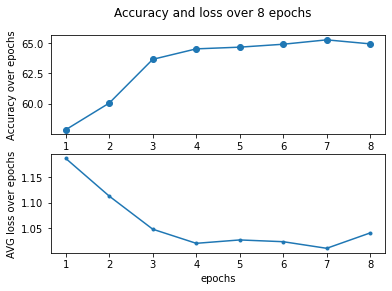

In [8]:
xVals = list(range(1, epochs + 1))

fig, (ax1, ax2) = plt.subplots(2, 1)    
fig.suptitle(f"Accuracy and loss over {epochs} epochs")

ax1.plot(xVals, accuracies, 'o-')
ax2.set_xlabel("epochs")
ax1.set_ylabel("Accuracy over epochs")

ax2.plot(xVals, losses, '.-')
ax2.set_xlabel("epochs")
ax2.set_ylabel("AVG loss over epochs")

plt.show()

#### Saving the model
Not strictly necessary.

In [9]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

### Testing the network (model)


tensor([2, 5, 6, 1])


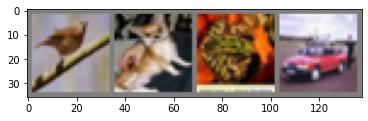

GroundTruth:  bird  dog   frog  car  
Predicted:  cat   dog   frog  car  


In [13]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
# The "iter( )" function makes an object iterable.
# Meaning that we still can't subscribt it, however we can call the next 
# "instance" (I guess is an apt name), over and over. 
dataiter = iter(trainloader)
images, labels = dataiter.next()
#print(f"shape of the images 'Tensor': {images.shape}")

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

model = CNN()
model.load_state_dict(torch.load(PATH))

outputs = model(images)

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

## Integrated Gradients stuff
Now we will try to apply some of the attribution algorithms, to one of the pictures, to see whether it works.

In [11]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

# Sets the model to eval mode for intepretratation purposes
# (whatever that is supposed to mean).
model.eval()


# Then there is this weird function definition
# (I am unsure what it does)
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=labels[ind], **kwargs)
    
    return tensor_attributions
        

# This is then supposed to be calculating the gradients for the saliency maps
# (and also transposing the image for some reason..)
saliency = Saliency(model)
grads = saliency.attribute(input, target=labels[ind].item())
# Here I think it just sorts out the stuff with the channels
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))   


# This applies the integrated gradient attribution algorithm.
# (Don't know entirely what is supposed to be doing either).
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))


# Some more attribution algorithms:
# with some kind of standard Gaussian noise
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, input, baselines=input * 0, nt_type='smoothgrad_sq', nt_samples=100, stdevs=0.2
    )
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))


# Something called deeplift:
dl = DeepLift(model)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))     

Approximation delta:  tensor([0.0441], dtype=torch.float64)


c:\Users\daflo\Documents\DTU\Semester_6\Bachelor\Code\Bachelor_venv\lib\site-packages\captum\attr\_core\deep_lift.py:320: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


### Showing the stuff

Finally.. after all that definition and code, we show the saliency maps.

Original Image
Predicted: deer  Probability: 0.9984750151634216


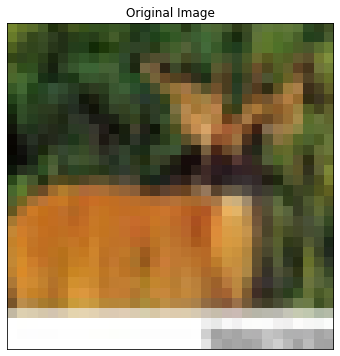

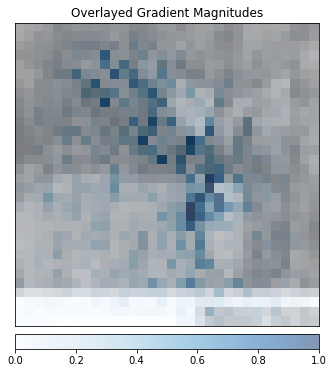

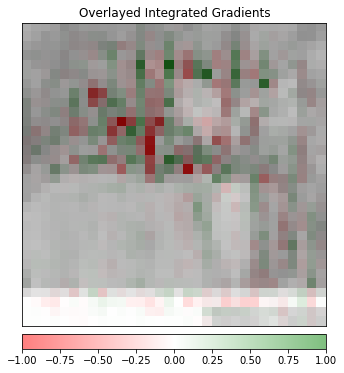

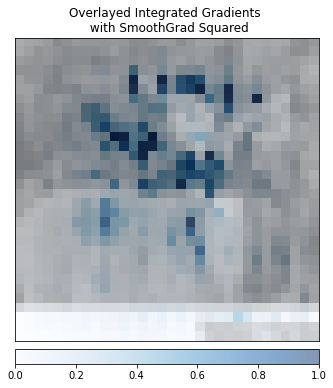

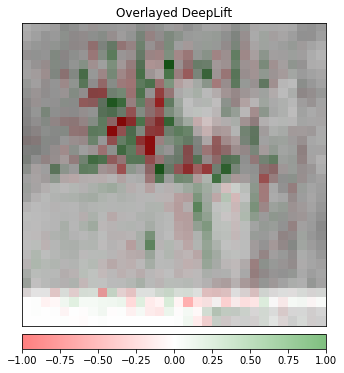

In [12]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")